In [3]:
import pandas as pd
import pickle as pkl
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import warnings
warnings.filterwarnings('ignore')
dt = 'risk-models-benchmark-v1_digraph'

with open('../datasets/' + dt + '.pkl', "rb") as file:
    g = pkl.load(file)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['causal', 'non_causal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def fold_analysis(g, ocl, emb_name, final_run):
    df_egae = pd.DataFrame()

    df_egae['y'] = [g.nodes[node]['label'] for node in g.nodes()]
    df_egae['x'] = [g.nodes[node][emb_name] for node in g.nodes()]

    df = df_egae[df_egae['y'] != 'aux'].reset_index(drop=True)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_trues, y_preds = [], []

    for train_index, test_index in kf.split(df['x'], df['y']):

        x_train = df[(df.index.isin(train_index)) & (df['y'] == 'causal')]['x'].to_list()
        
        x_test = df[df.index.isin(test_index)]['x'].to_list()
        y_true = df[df.index.isin(test_index)]['y'].to_list()

        ocl = ocl.fit(x_train)

        y_pred = ocl.predict(x_test)

        y_pred = ['causal' if y == 1 else 'non_causal' for y in y_pred]

        f1_macro = classification_report(y_true, y_pred, output_dict=True)['macro avg']['f1-score']
        if final_run:
            print(round(f1_macro, 3), end=" & ")

        y_trues = np.concatenate([y_trues,y_true])
        y_preds = np.concatenate([y_preds,y_pred])

    f1_avg = round(classification_report(y_trues, y_preds, output_dict=True)['macro avg']['f1-score'], 3)

    if final_run:
        print(f1_avg)
        plot_confusion_matrix(y_trues, y_preds)
    else:
        return f1_avg

In [9]:
maior = 0
emb_name = 'embedding'
for gamma in ['auto', 'scale']:
    for kernel in ['linear', 'poly', 'sigmoid', 'rbf']:
        for nu in [n*0.05 for n in range(1,19)]:
            ocl = OneClassSVM(nu=nu, gamma=gamma, kernel=kernel)
            f1 = fold_analysis(g, ocl, emb_name, False)
            if f1 > maior:
                maior = f1
                print(gamma + ' ' +  kernel + ' ' + str(nu))

auto linear 0.05
auto linear 0.1
auto linear 0.15000000000000002
auto linear 0.2
auto linear 0.25
auto linear 0.30000000000000004
auto linear 0.35000000000000003
auto linear 0.4
auto poly 0.75
auto poly 0.8
scale poly 0.05
scale poly 0.1
scale poly 0.25


In [ ]:
maior = 0
emb_name = 'embedding'
for n_estimators in [1,2,5,10,50,100,200,500]:
    for max_samples in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        for max_features in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            ocl = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, random_state=81)
            f1 = fold_analysis(g, ocl, emb_name, False)
            if f1 > maior:
                maior = f1
                print(str(n_estimators) + ' ' +  str(max_samples) + ' ' + str(max_features))

0.48 & 0.492 & 0.477 & 0.463 & 0.539 & 0.493


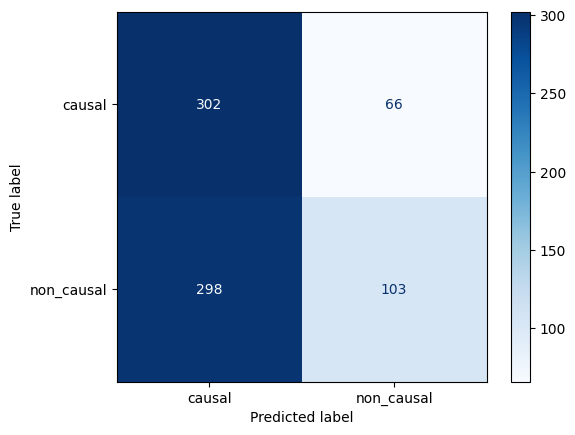

In [14]:
IsolationForest(n_estimators=1, max_samples=1.0, max_features=0.2, random_state=81)
fold_analysis(g, ocl, emb_name, True)

0.634 & 0.659 & 0.659 & 0.688 & 0.718 & 0.672


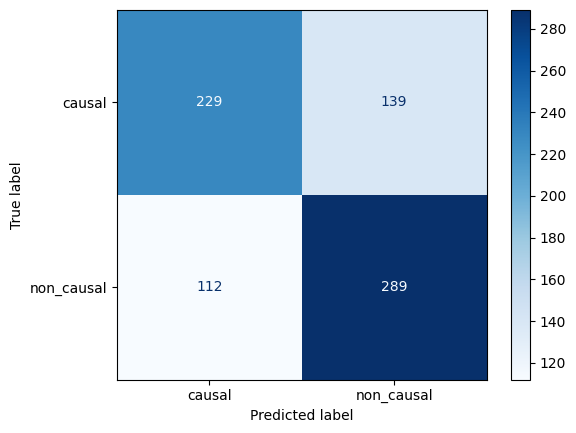

In [16]:
ocl = OneClassSVM(nu=0.25, gamma='scale', kernel='poly')
fold_analysis(g, ocl, emb_name,True)